# Survival Analysis - test cricket

### Setup and loading data

In [1]:
import lifelines
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline


Load data from https://cricsheet.org/

In [2]:
files = os.listdir('test_csv')
files = [f for f in files if '.csv' in f]

This is the expensive section. Run on subset of files for simpler 

In [3]:
cric_df = pd.DataFrame()
cric_cols = ['type','innings','ball','team','bat_1','bat_2','bowl','runs','byes','wicket','player_out']
for i, file in enumerate(files):
    df = pd.read_csv('test_csv/'+file, error_bad_lines=False,names=cric_cols)
    df['match_id'] = i
    cric_df=cric_df.append(df,sort=False)
    

For now, drop match metadata (note this could be used to generate features).

In [4]:

cric_df = cric_df[cric_df['type']=='ball']
cric_df.head()



,type,innings,ball,team,bat_1,bat_2,bowl,runs,byes,wicket,player_out,match_id
24,ball,1,0.1,South Africa,SC Cook,D Elgar,MA Starc,0.0,0.0,NaN,NaN,0
25,ball,1,0.2,South Africa,SC Cook,D Elgar,MA Starc,0.0,0.0,NaN,NaN,0
26,ball,1,0.3,South Africa,SC Cook,D Elgar,MA Starc,0.0,0.0,NaN,NaN,0
27,ball,1,0.4,South Africa,SC Cook,D Elgar,MA Starc,0.0,0.0,caught,SC Cook,0
28,ball,1,0.5,South Africa,HM Amla,D Elgar,MA Starc,0.0,0.0,NaN,NaN,0


### Calculating innings-level stats

Was the player out? For now ignoring runouts (maybe better anyway)?

In [5]:
cric_df['is_out']=(cric_df['player_out']==cric_df['bat_1'])


What is the first ball faced by the player? (so we can find their place in batting order..).

In [6]:
cric_df['first_ball'] = cric_df.index

Aggregate to innings-level granularity

In [7]:
innings_totals = cric_df.groupby(['team','match_id','innings','bat_1']).agg({'runs':'sum', 
                         'is_out':'sum', 
                         'first_ball':'min'})


What number did the player bat? Calculated by using rank of bat_number, by innings.

In [8]:
innings_totals['bat_number'] = innings_totals.groupby(['team','match_id','innings']).rank()['first_ball']

innings_totals.reset_index(inplace=True)
innings_totals['innings']= pd.to_numeric(innings_totals['innings'])

innings_totals.head()

,team,match_id,innings,bat_1,runs,is_out,first_ball,bat_number
0,Australia,0,2,AC Voges,27.0,True,660,5.0
1,Australia,0,2,DA Warner,97.0,True,408,1.0
2,Australia,0,2,JR Hazlewood,4.0,True,819,10.0
3,Australia,0,2,MA Starc,0.0,True,779,8.0
4,Australia,0,2,MR Marsh,0.0,True,693,6.0


 Simple histograms

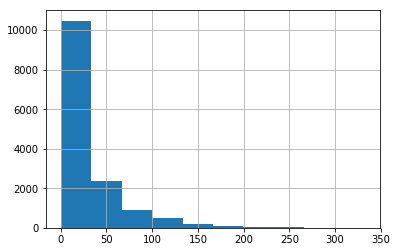

In [9]:
innings_totals['runs'].hist()


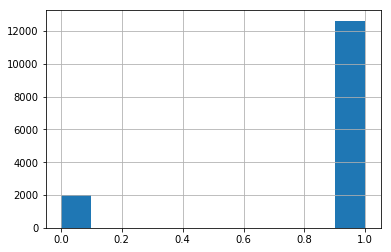

In [10]:
innings_totals['is_out'].hist()

### KMF model

In [11]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(innings_totals['runs'], event_observed=innings_totals['is_out'], label="All players Kaplan Meier")

<lifelines.KaplanMeierFitter: fitted with 14620 observations, 1987 censored>

Plotting the output

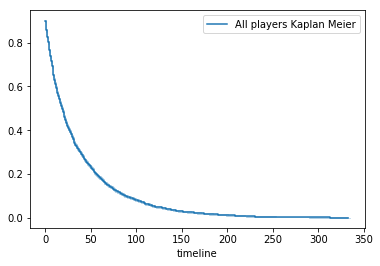

In [12]:
kmf.survival_function_
kmf.median_
kmf.plot()

Comparing survival curve for different innings

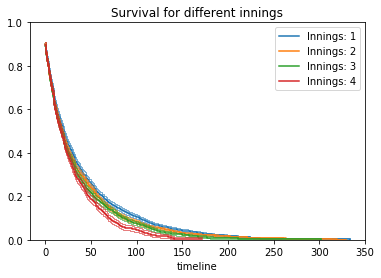

In [13]:

ax = plt.subplot(111)

for i in range(1,5):
    data = innings_totals[innings_totals["innings"] == i]
    kmf.fit(data['runs'], event_observed=data['is_out'], label="Innings: {}".format(i))
    kmf.plot(ax=ax, ci_force_lines=True)
    
plt.ylim(0, 1);
plt.title("Survival for different innings");

And for different batting numbers

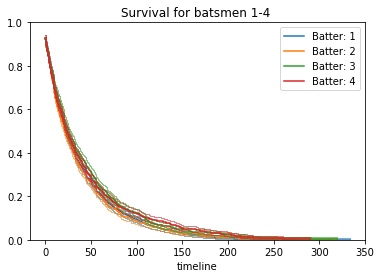

In [14]:
ax = plt.subplot(111)

for i in range(1,5):
    data = innings_totals[innings_totals["bat_number"] == i]
    kmf.fit(data['runs'], event_observed=data['is_out'], label="Batter: {}".format(i))
    kmf.plot(ax=ax, ci_force_lines=True)
    
plt.ylim(0, 1);
plt.title("Survival for batsmen 1-4 ");

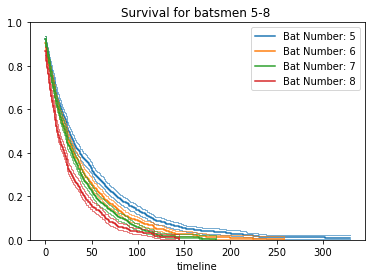

In [15]:
ax = plt.subplot(111)

for i in range(5,9):
    data = innings_totals[innings_totals["bat_number"] == i]
    kmf.fit(data['runs'], event_observed=data['is_out'], label="Bat Number: {}".format(i))
    kmf.plot(ax=ax, ci_force_lines=True)
    
plt.ylim(0, 1);
plt.title("Survival for batsmen 5-8 ");

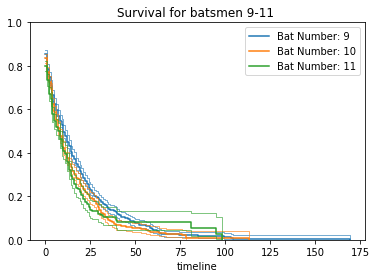

In [16]:
ax = plt.subplot(111)

for i in range(9,12):
    data = innings_totals[innings_totals["bat_number"] == i]
    kmf.fit(data['runs'], event_observed=data['is_out'], label="Bat Number: {}".format(i))
    kmf.plot(ax=ax, ci_force_lines=True)
    
plt.ylim(0, 1);
plt.title("Survival for batsmen 9-11 ");

### CPH model

Train model

In [17]:
cph = lifelines.CoxPHFitter()

cox_data = innings_totals[['innings','bat_number','runs','is_out']]

cox_data = pd.get_dummies(cox_data)
cph.fit(df=cox_data, duration_col='runs', event_col='is_out')


<lifelines.CoxPHFitter: fitted with 14620 observations, 1987 censored>

Evaluate outcomes

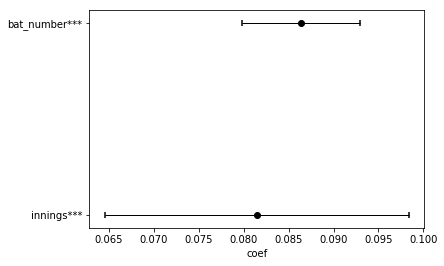

In [18]:
cph.plot()

In [19]:
cph.print_summary()

n=14620, number of events=12633

             coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
innings    0.0814     1.0849    0.0086  9.4215 0.0000      0.0645      0.0984  ***
bat_number 0.0864     1.0902    0.0034 25.7555 0.0000      0.0798      0.0930  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.577
Likelihood ratio test = 713.547 on 2 df, p=0.00000


In [34]:
X = cox_data.drop(['runs', 'is_out'], axis=1)
d = {'innings': [1, 2,4,3], 'bat_number': [1, 3,10,1]}
test_cases=pd.DataFrame(data=d,index=['innings 1 - number 1','innings 2 - number - 3', 'innings 4 - number 10','cook - 3rd innings']);test_cases

,innings,bat_number
innings 1 - number 1,1,1
innings 2 - number - 3,2,3
innings 4 - number 10,4,10
cook - 3rd innings,3,1


Predict for specific outcomes / scores

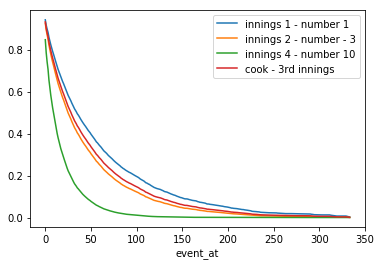

In [37]:
cox_predictions = cph.predict_survival_function(test_cases)
cox_predictions.plot()

### How likely was Cook to make a centruy at various stages?

In [67]:
for curr_score in (0,50,72,90):
    survival_odds = cox_predictions['cook - 3rd innings'][100-curr_score]
    print('Odds of century at score {} - {:.1f}%'.format(curr_score,survival_odds*100))



Odds of century at score 0 - 14.6%
Odds of century at score 50 - 33.7%
Odds of century at score 72 - 50.1%
Odds of century at score 90 - 72.7%
